In [41]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential


In [42]:
#Dimensionality
imgRow = 28
imgCols = 28
channels = 1

imgShape = (imgRow,imgCols,channels)
zDim = 100

In [61]:
#Generator
def buildGenerator(imgShape,zDim):
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [62]:
buildGenerator(imgShape,zDim).summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 3136)              316736    
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 14, 14, 32)       32800     
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 28, 28, 1)      

In [85]:
#Discriminator
def buildDiscriminator(imgShape):
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [86]:
buildDiscriminator(imgShape).summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         131200    
                                                                 
 batch_normalization_23 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                     

In [87]:
#GAN
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [88]:
#Compiler
discriminator = buildDiscriminator(imgShape=imgShape)
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

generator = buildGenerator(imgShape=imgShape,zDim=zDim)

discriminator.trainable = False

gan = buildGan(generator=generator,discriminator=discriminator)
gan.compile(optimizer="adam",loss="binary_crossentropy")

In [89]:
#Training algorithm 
losses=[]
accuracies = []
iterations = []

def training(iteration, batchSize,sampleInterval):
    (xTrain, _), (_,_) = mnist.load_data()
    xTrain = xTrain/127.5-1
    xTrain = np.expand_dims(xTrain,axis=3)

    real = np.ones((batchSize,1))
    fake = np.zeros((batchSize,1))

    #Train discriminator
    for iter in range(iteration):
        idx = np.random.randint(0,xTrain.shape[0],batchSize)
        imgs = xTrain[idx]

        z = np.random.normal(0,1,(batchSize,100))
        genImgs = generator.predict(z)

        dLossReal = discriminator.train_on_batch(imgs,real)
        dLossFake = discriminator.train_on_batch(genImgs,fake)
        dLoss, accuracy = 1/2 * np.add(dLossReal,dLossFake)
    
        #Train generator
        z = np.random.normal(0,1,(batchSize,100))
        genImgs = generator.predict(z)

        gLoss = gan.train_on_batch(z,real)

        if (iter +1)%sampleInterval ==0:
            losses.append((dLoss,gLoss))
            accuracies.append((100.*accuracy))
            iterations.append(iter+1)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iter + 1, dLoss, 100.0 * accuracy, gLoss))
            sampleImg(generator)



In [90]:
def sampleImg(generator,imgGridRow = 4, imgGridColumn = 4):
    z = np.random.normal(0,1,(imgGridRow*imgGridColumn,zDim))
    genImg = generator.predict(z)
    genImg = 1/2*genImg+0.5

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(4,4),sharey = True,sharex=True)
    
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt,:,:,0],cmap="gray")
            axs[i,j].axis("off")
            cnt+=1

1000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000295]
2000 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000079]
3000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000100]
4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000064]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000028]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000029]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000010]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000007]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000005]


KeyboardInterrupt: 

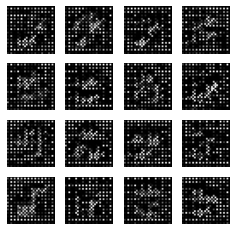

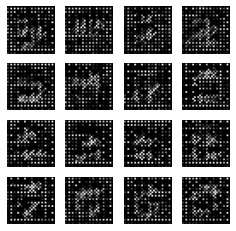

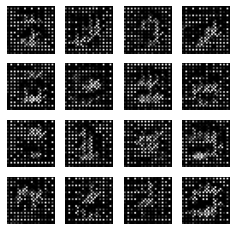

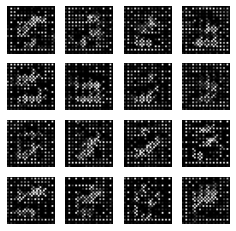

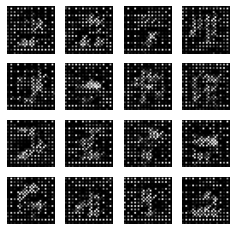

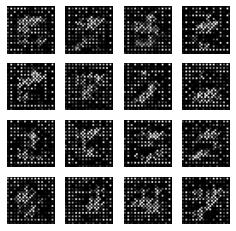

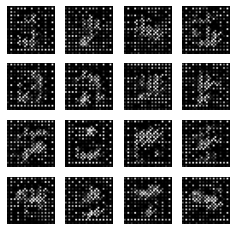

In [92]:
#activate hyperparameters
iteration = 20000
batchSize = 128
sampleInter = 1000

with tf.device('/gpu:0'):
    c = training(iteration,batchSize,sampleInter)

with tf.Session() as sess:
    print (sess.run(c))